In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.set_printoptions(precision=4)

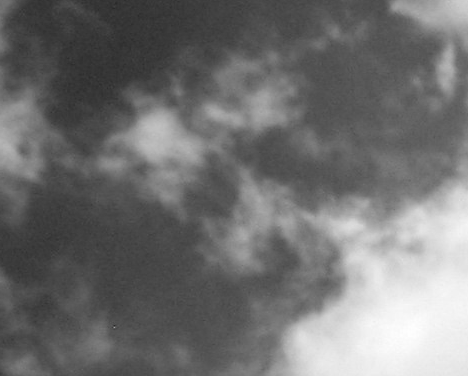

In [3]:
# g === area (big image)
# f === fragment
g = Image.open('img/20160825-143207-156-2_aff_applied.png').convert('L')

wg = g.width // 6
hg = g.height // 6
xg = 200
yg = 200

box = (xg, yg, xg + wg, yg + hg)
g = g.crop(box)
g

In [4]:
print g.size
g_mat = np.asarray(g.getdata(), dtype=int).reshape(g.size[1], g.size[0])

(468, 376)


(100, 100)
160 226


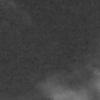

In [5]:
# Crop fragment from area image
wf = 100
hf = 100
# For moving averages computing -- not needed anymore
offset_x = 20
offset_y = 20
xf = np.random.randint(offset_x, g.size[0] - wf - offset_x)
yf = np.random.randint(offset_y, g.size[1] - hf - offset_y)


crop_box = (xf, yf, xf + wf, yf + hf)
f = Image.open("img/20160825-143207-156-1_aff_applied.png").convert('L')
f = f.crop(crop_box)
print f.size
print yf, xf
f

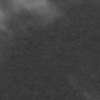

In [6]:
# Create matrix of fragment
f_mat = np.asarray(f.getdata(), dtype=int).reshape(f.size[1], f.size[0])
# Flip matrix
f_mat = np.fliplr(f_mat)
f_mat = np.flipud(f_mat)

Image.fromarray(f_mat.astype('uint8'), 'L')

In [7]:
num_shades = 256
# Create indicators of f
# of size == g.size
chi = np.zeros((num_shades, g.size[1], g.size[0]), dtype=bool)

In [8]:
# fill the indicators
for h in xrange(f.size[1]):
    for w in xrange(f.size[0]):
        color = f_mat[h, w]
        chi[color, h, w] = True

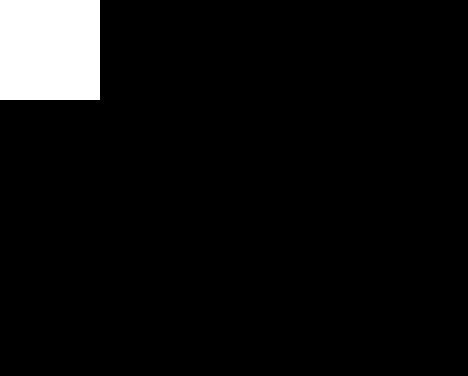

In [9]:
Image.fromarray(chi.sum(axis=0).astype('uint8')*(num_shades - 1), 'L')

In [10]:
# chi_elems[i] === number of pixels that have color "i"
chi_elems = np.array( f.histogram() )
print chi_elems

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    1    1    4   11   27   48   95  232  404  640  714  893 1001
  905  788  585  502  313  235  189  157  168  173  116  113  117  112   80
   71   59   59   48   47   36   41   42   38   38   24   31   49   46   38
   40   38   37   37   27   33   24   23   26   20   22   27   19   27   16
   22   15    9   15   19   21   19   19   20   20   31   11   14   14   15
    8   10    9    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0  

In [11]:
fft_chi = np.fft.fft2(chi)

In [12]:
fft_g = np.fft.fft2(g_mat)

In [13]:
# Scalar product (g_frag, chi[i])
sp_g_frag_chi = np.zeros((num_shades, g.size[1] - hf, g.size[0] - wf))

for i in xrange(num_shades):
    if chi_elems[i] > 0:
        sp_g_frag_chi[i] = np.fft.ifft2(fft_g * fft_chi[i])[hf:, wf:]

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ComplexWarning: Casting complex values to real discards the imaginary part


In [14]:
# || Projection of g_frag on f ||^2
norm_pr_gfrag_sqr = np.zeros((g.size[1] - hf, g.size[0] - wf))
for i in xrange(num_shades):
    if chi_elems[i] > 0:
        norm_pr_gfrag_sqr += sp_g_frag_chi[i] ** 2 / float(chi_elems[i])

In [15]:
# chi_X -- const field of vision
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 1 1 1 0 0 ... 0
# 0 0 0 0 0 ... 0
# . . .
# 0 0 0 0 0 ... 0
chi_X = np.zeros((g.size[1], g.size[0]), dtype=bool)
chi_X[:hf, :wf] = np.ones((hf, wf))


# || g ||^2
fft_gsqr = np.fft.fft2(g_mat ** 2)
fft_chi_X = np.fft.fft2(chi_X)
norm_gfrag_sqr = np.fft.ifft2(fft_gsqr * fft_chi_X)[hf:, wf:].astype('float')

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: ComplexWarning: Casting complex values to real discards the imaginary part


In [16]:
# E_gfrag = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float')
norm_E_gfrag_sqr = np.fft.ifft2(fft_g * fft_chi_X)[hf:, wf:].astype('float') \
                        ** 2 / (hf * wf)

/home/stan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


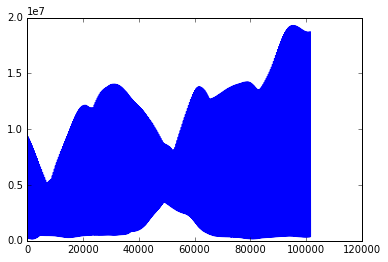

In [17]:
numerator = norm_gfrag_sqr - norm_pr_gfrag_sqr
plt.plot(numerator.ravel())

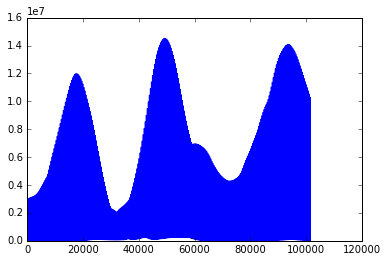

In [18]:
denominator = norm_pr_gfrag_sqr - norm_E_gfrag_sqr
plt.plot(denominator.ravel())

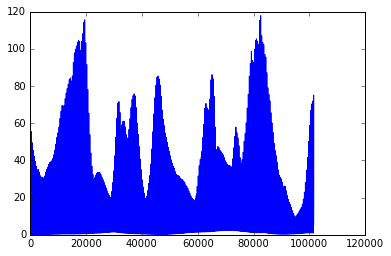

In [19]:
tau = abs(numerator) / abs(denominator)
plt.plot(tau.ravel())

In [21]:
true_idx = yf * tau.shape[1] + xf
index = tau.argmin() 
x_min = index % tau.shape[1] + 1
y_min = index // tau.shape[1] + 1
print index
print 'Should be:', true_idx
print "y_min, x_min: %d %d" % (yg + y_min, xg + x_min)
print 'Should be:', (yf, xf)

 2287
Should be: 59106
y_min, x_min: 207 280
Should be: (160, 226)


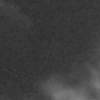

In [22]:
Image.fromarray(g_mat[y_min : y_min + hf , x_min : x_min + wf].astype('uint8'), 'L')

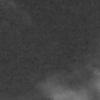

In [23]:
f